https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [1]:
import pandas as pd

In [112]:
train = pd.read_csv(r'archive(1)/train.txt', sep=";" , header=None)
train.columns = ["tweet", "feeling"]

In [113]:
test = pd.read_csv("archive(1)/test.txt", sep=";", names=["tweet", "feeling"])
val = pd.read_csv("archive(1)/val.txt", sep=";", names=["tweet", "feeling"])

In [114]:
train.head()

,tweet,feeling
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [115]:
train.isnull().sum()

tweet      0
feeling    0
dtype: int64

In [116]:
train.duplicated().sum()

1

In [117]:
train.shape[0]

16000

In [118]:
train = train.drop_duplicates()

In [119]:
train.shape[0]

15999

## text cleaning

In [120]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    return text.strip()

train["tweet"] = train["tweet"].apply(clean_text)
test["tweet"] = test["tweet"].apply(clean_text)
val["tweet"] = val["tweet"].apply(clean_text)

In [110]:
#supprimer les stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

train['tweet'] = train['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
test['tweet'] = test['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
val['tweet'] = val['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


## text preprocessing

## model preparation

In [121]:
# Vectorisation du texte
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train["tweet"])
X_test = vectorizer.transform(test["tweet"])
X_val = vectorizer.transform(val["tweet"])


we can try glove, bert, word2Vec later

## analyse exploratoire

<Axes: xlabel='feeling'>

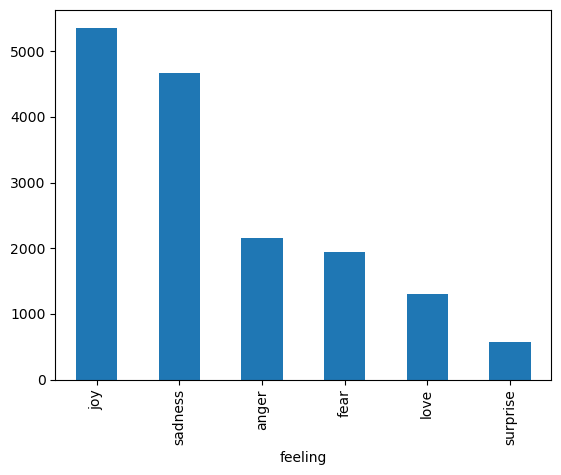

In [123]:
# fréquence des sentiments
train['feeling'].value_counts().plot(kind='bar')

In [56]:
# tokenisation
from nltk.tokenize import word_tokenize
train['tokens'] = train['tweet'].apply(word_tokenize)
test['tokens'] = test['tweet'].apply(word_tokenize)
val['tokens'] = val['tweet'].apply(word_tokenize)

In [57]:
#lemmatisation (steeming)
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

train['tokens'] = train['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])
test['tokens'] = test['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])
val['tokens'] = val['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(w) for w in tokens])


<Axes: xlabel='feeling'>

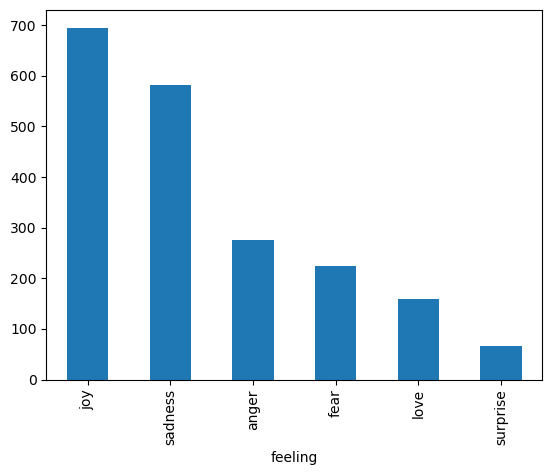

In [125]:
test['feeling'].value_counts().plot(kind='bar')

In [124]:
train['feeling'].value_counts()

feeling
joy         5361
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

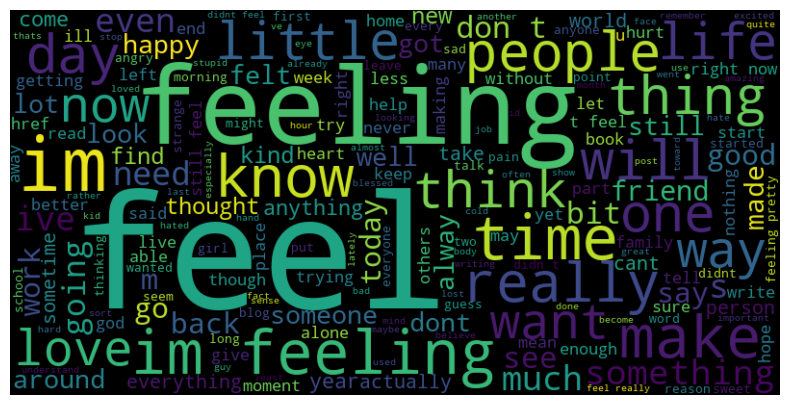

In [127]:
#Nuage de mots
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(train['tweet'])
wordcloud = WordCloud(width=800, height=400).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## encodage des labels

In [128]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(train["feeling"])
y_test = encoder.transform(test["feeling"])
y_val = encoder.transform(dev["feeling"])

## 🤖  Entraîner un modèle de classification

In [129]:
# exemple avec regression logistique
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [130]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

       anger       0.90      0.82      0.86       275
        fear       0.89      0.79      0.83       224
         joy       0.84      0.96      0.89       695
        love       0.83      0.60      0.70       159
     sadness       0.90      0.93      0.91       581
    surprise       0.85      0.52      0.64        66

    accuracy                           0.87      2000
   macro avg       0.87      0.77      0.81      2000
weighted avg       0.87      0.87      0.86      2000



In [131]:
# Prédictions sur le set de validation
y_val_pred = model.predict(X_val)

# Évaluation sur le set de validation
from sklearn.metrics import classification_report, confusion_matrix

print("Évaluation sur le jeu de validation (val.txt) :\n")
print(classification_report(y_val, y_val_pred, target_names=encoder.classes_))


Évaluation sur le jeu de validation (val.txt) :

              precision    recall  f1-score   support

       anger       0.91      0.82      0.87       275
        fear       0.85      0.75      0.80       212
         joy       0.85      0.94      0.89       704
        love       0.89      0.64      0.75       178
     sadness       0.86      0.94      0.90       550
    surprise       0.84      0.58      0.69        81

    accuracy                           0.86      2000
   macro avg       0.87      0.78      0.81      2000
weighted avg       0.86      0.86      0.86      2000



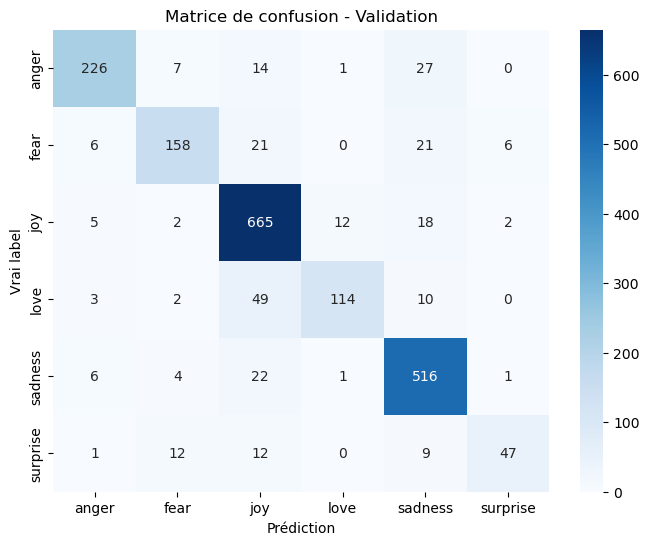

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_, cmap="Blues")
plt.xlabel('Prédiction')
plt.ylabel('Vrai label')
plt.title("Matrice de confusion - Validation")
plt.show()

| Étape                      | Logistic Regression | XGBoost | LSTM (RNN) |
| -------------------------- | ------------------- | ------- | ---------- |
| TF-IDF                     | ✅                   | ✅       | ❌          |
| Tokenizer + pad\_sequences | ❌ (pas utile ici)   | ❌       | ✅          |


In [133]:
# 1. Importation des bibliothèques
from xgboost import XGBClassifier

In [134]:
#Modèle XGBoost avec early stopping sur le jeu de validation
model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(encoder.classes_),
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=500,
    early_stopping_rounds=10,
    learning_rate=0.1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_dev, y_dev)],
    verbose=True
)

C:\ProgramData\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [20:17:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:1.76590
[1]	validation_0-mlogloss:1.74426
[2]	validation_0-mlogloss:1.72463
[3]	validation_0-mlogloss:1.70722
[4]	validation_0-mlogloss:1.69216
[5]	validation_0-mlogloss:1.67893
[6]	validation_0-mlogloss:1.66735
[7]	validation_0-mlogloss:1.65675
[8]	validation_0-mlogloss:1.64738
[9]	validation_0-mlogloss:1.63919
[10]	validation_0-mlogloss:1.63181
[11]	validation_0-mlogloss:1.62524
[12]	validation_0-mlogloss:1.61929
[13]	validation_0-mlogloss:1.61434
[14]	validation_0-mlogloss:1.60972
[15]	validation_0-mlogloss:1.60578
[16]	validation_0-mlogloss:1.60247
[17]	validation_0-mlogloss:1.59923
[18]	validation_0-mlogloss:1.59630
[19]	validation_0-mlogloss:1.59391
[20]	validation_0-mlogloss:1.59188
[21]	validation_0-mlogloss:1.59006
[22]	validation_0-mlogloss:1.58842
[23]	validation_0-mlogloss:1.58681
[24]	validation_0-mlogloss:1.58561
[25]	validation_0-mlogloss:1.58916
[26]	validation_0-mlogloss:1.58814
[27]	validation_0-mlogloss:1.58751
[28]	validation_0-mlogloss:1.5

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=6, ...)

In [135]:
#Évaluation finale sur le test set
y_pred = model.predict(X_test)

print("Évaluation sur le jeu de test :\n")
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

Évaluation sur le jeu de test :

              precision    recall  f1-score   support

       anger       0.96      0.61      0.74       275
        fear       0.94      0.53      0.68       224
         joy       0.60      0.96      0.74       695
        love       0.85      0.53      0.65       159
     sadness       0.96      0.67      0.79       581
    surprise       0.65      0.71      0.68        66

    accuracy                           0.74      2000
   macro avg       0.83      0.67      0.71      2000
weighted avg       0.81      0.74      0.74      2000



## enregistrer le modèle

In [140]:
import joblib
joblib.dump(model, "xgboost_emotion_model.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(encoder, "label_encoder.pkl")

['label_encoder.pkl']

# Neural Network

In [146]:
!python --version

Python 3.11.5


## ✅ Avantages de BERT (et DistilBERT pour être léger) :

| ✅                                | Pourquoi c’est mieux                      |
| -------------------------------- | ----------------------------------------- |
| 🧠 Comprend le contexte          | « I hate him » ≠ « I love him »           |
| 🚫 Gère les négations            | « not happy » n’est plus classé comme joy |
| 🔄 Déjà pré-entraîné             | Pas besoin de gros dataset                |
| 💡 Robuste aux tournures variées | Il comprend aussi « I’m done with him »   |


In [148]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
import torch

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [150]:
# Encodage des labels
label_encoder = LabelEncoder()
train["label"] = label_encoder.fit_transform(train["feeling"])
val["label"] = label_encoder.transform(val["feeling"])
test["label"] = label_encoder.transform(test["feeling"])

In [153]:
# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["tweet"], truncation=True, padding=True)

In [154]:
# Conversion en datasets Hugging Face
train_ds = Dataset.from_pandas(train)
val_ds = Dataset.from_pandas(val)
test_ds = Dataset.from_pandas(test)

train_ds = train_ds.map(tokenize_function, batched=True)
val_ds = val_ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/15999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [155]:
# Charger modèle
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

# Entraînement
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [156]:
def compute_metrics(p):
    from sklearn.metrics import accuracy_score, f1_score
    preds = p.predictions.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1": f1_score(p.label_ids, preds, average="macro")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.231300,0.193684,0.927500,0.890825
2,0.142900,0.175216,0.932500,0.905315
3,0.095600,0.171601,0.941500,0.916661
4,0.059900,0.186264,0.946500,0.926178


TrainOutput(global_step=4000, training_loss=0.17938431644439698, metrics={'train_runtime': 50718.2593, 'train_samples_per_second': 1.262, 'train_steps_per_second': 0.079, 'total_flos': 1379826583844760.0, 'train_loss': 0.17938431644439698, 'epoch': 4.0})

In [157]:
from transformers import pipeline
import torch

# Créer un pipeline rapide depuis ton modèle entraîné
clf = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Test de quelques phrases
texts = [
    "I am happy today!",
    "I'm scared and I don't want to go outside",
    "I love you so much",
    "I will block him and never talk to him again"
]

# Prédiction
for text in texts:
    result = clf(text)[0]
    result = sorted(result, key=lambda x: x["score"], reverse=True)
    print(f"\n📝 Text: {text}")
    for r in result:
        label = label_encoder.inverse_transform([int(r['label'].split('_')[-1])])[0]
        print(f"🔮 {label}: {r['score']:.3f}")


C:\ProgramData\anaconda3\Lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(



📝 Text: I am happy today!
🔮 joy: 1.000
🔮 love: 0.000
🔮 anger: 0.000
🔮 sadness: 0.000
🔮 surprise: 0.000
🔮 fear: 0.000

📝 Text: I'm scared and I don't want to go outside
🔮 fear: 0.999
🔮 anger: 0.000
🔮 sadness: 0.000
🔮 joy: 0.000
🔮 surprise: 0.000
🔮 love: 0.000

📝 Text: I love you so much
🔮 love: 0.998
🔮 joy: 0.002
🔮 sadness: 0.000
🔮 anger: 0.000
🔮 fear: 0.000
🔮 surprise: 0.000

📝 Text: I will block him and never talk to him again
🔮 anger: 0.997
🔮 sadness: 0.002
🔮 fear: 0.000
🔮 joy: 0.000
🔮 love: 0.000
🔮 surprise: 0.000


In [158]:
# Save the model
model.save_pretrained("bert_emotion_model")
tokenizer.save_pretrained("bert_emotion_model")

import joblib
joblib.dump(label_encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [2]:
# 1. Connexion à Hugging Face
from huggingface_hub import login
login()  # Colle ton token ici

In [3]:
# 2. Charger le modèle et le tokenizer depuis le dossier local
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

model = DistilBertForSequenceClassification.from_pretrained("bert_emotion_model")
tokenizer = DistilBertTokenizerFast.from_pretrained("bert_emotion_model")

# 3. Envoyer sur Hugging Face
model.push_to_hub("bert-emotion-app")
tokenizer.push_to_hub("bert-emotion-app")

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Ikraaaam/bert-emotion-app/commit/de384e9e9c06cde03ab22f6c7e3eb6a6cffc8842', commit_message='Upload tokenizer', commit_description='', oid='de384e9e9c06cde03ab22f6c7e3eb6a6cffc8842', pr_url=None, pr_revision=None, pr_num=None)

Qu’est-ce qu’un RNN ?

Un RNN (Recurrent Neural Network) est un modèle conçu pour traiter des données séquentielles comme du texte, du son, etc.

Mais les RNN classiques ont deux gros problèmes :

    Le vanishing gradient (ils oublient les mots trop loin dans la séquence)

    Ils sont lents à entraîner pour de longues séquences

➡️ Pour résoudre ça, on utilise LSTM ou GRU.

## 🔁 LSTM vs GRU : les différences

| Feature                   | **LSTM**                 | **GRU**                          |
| ------------------------- | ------------------------ | -------------------------------- |
| 🧱 Architecture           | Plus complexe (3 portes) | Plus simple (2 portes)           |
| 🕰️ Mémoire à long terme  | Oui (`cell state`)       | Moins séparée (`hidden state`)   |
| ⚙️ Paramètres à entraîner | Plus nombreux            | Moins nombreux                   |
| 🚀 Vitesse d’entraînement | Plus lent                | Plus rapide                      |
| 📈 Performance            | Parfois un peu meilleure | Parfois équivalente ou meilleure |


## 🧬 Les deux ont :

    Une porte de mise à jour

    Une porte d’oubli (seulement dans LSTM)

    Une porte de sortie (seulement dans LSTM)

    Une capacité à conserver la mémoire sur plusieurs tokens (mots)

## 🟢 En résumé :

    LSTM : Plus puissant pour capturer des dépendances complexes sur de longues séquences (par exemple en NLP profond)

    GRU : Plus rapide, moins gourmand, souvent tout aussi bon

In [95]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense , Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


In [90]:
# Encodage des émotions
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(train["feeling"])
y_val_enc = encoder.transform(dev["feeling"])
y_test_enc = encoder.transform(test["feeling"])

# Calcul du class_weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_enc),
    y=y_train_enc
)
class_weight_dict = dict(zip(np.unique(y_train_enc), class_weights))

In [91]:
# Conversion en one-hot
y_train = to_categorical(y_train_enc)
y_val = to_categorical(y_val_enc)
y_test = to_categorical(y_test_enc)

## tokenization + padding

In [93]:
max_vocab = 10000
max_len = 50

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(train["tweet"])

X_train = pad_sequences(tokenizer.texts_to_sequences(train["tweet"]), maxlen=max_len, padding="post")
X_val   = pad_sequences(tokenizer.texts_to_sequences(val["tweet"]), maxlen=max_len, padding="post")
X_test  = pad_sequences(tokenizer.texts_to_sequences(test["tweet"]), maxlen=max_len, padding="post")

### Modèle GRU

In [96]:
model_gru = Sequential([
    Embedding(input_dim=max_vocab, output_dim=128, input_length=max_len),
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
])

model_gru.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [77]:
#use the labeled values of the feeling
# One-hot encoding
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

## Entraînement avec early stopping

In [97]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1,
    class_weight=class_weight_dict
)


Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.1812 - loss: 1.7746 - val_accuracy: 0.2750 - val_loss: 1.7948
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.1471 - loss: 1.7906 - val_accuracy: 0.3520 - val_loss: 1.7803
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.1854 - loss: 1.7747 - val_accuracy: 0.0405 - val_loss: 1.7903
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 59ms/step - accuracy: 0.1120 - loss: 1.7968 - val_accuracy: 0.0890 - val_loss: 1.7937
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 30s 60ms/step - accuracy: 0.0917 - loss: 1.7836 - val_accuracy: 0.1060 - val_loss: 1.7961


## Évaluation sur le jeu de test

In [99]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00       275
        fear       0.00      0.00      0.00       224
         joy       0.35      1.00      0.52       695
        love       0.00      0.00      0.00       159
     sadness       0.00      0.00      0.00       581
    surprise       0.00      0.00      0.00        66

    accuracy                           0.35      2000
   macro avg       0.06      0.17      0.09      2000
weighted avg       0.12      0.35      0.18      2000



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 📊 Pourquoi GRU a échoué ici ?

| Problème                             | Explication                                                                |
| ------------------------------------ | -------------------------------------------------------------------------- |
| 💬 **Textes très courts**            | RNN n’a pas assez de contexte à exploiter                                  |
| 🧪 **Pas assez de données**          | Les RNN ont besoin de *beaucoup* d’exemples pour apprendre des séquences   |
| 🧱 **Pas de pre-trained embeddings** | Ton GRU a tout appris **from scratch**, donc il ne connaît aucun mot avant |
| 📐 **Surparamétrage**                | Trop de neurones → il apprend mal ou converge vers la classe dominante     |
